# Yolo-V1 from scratch

Reference: https://www.maskaravivek.com/post/yolov1/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow_datasets as tfds
import cv2

lrelu = tf.keras.layers.LeakyReLU(negative_slope=0.1)
strategy = tf.distribute.MirroredStrategy()

## VOC dataset

In [2]:
(train_ds, valid_ds, test_ds), ds_info = tfds.load('voc/2007',
                                        split=['train', 'validation', 'test'],
                                        with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.4BZ4C4_4.0.0/voc-test.tfrecord*...:   0%|          | 0…

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.4BZ4C4_4.0.0/voc-train.tfrecord*...:   0%|          | …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.4BZ4C4_4.0.0/voc-validation.tfrecord*...:   0%|       …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


In [3]:
classes = ['Person',
'Car',
'Bicycle',
'Bus',
'Motorbike',
'Train',
'Aeroplane',
'Chair',
'Bottle',
'Dining Table',
'Potted Plant',
'TV/Monitor',
'Sofa',
'Bird',
'Cat',
'Cow',
'Dog',
'Horse',
'Sheep']

In [4]:
IMG_SIZE = 448
NUM_CLASSES = 20
BATCH_SIZE = 16
classes.sort()

## Raw Visualization of Data

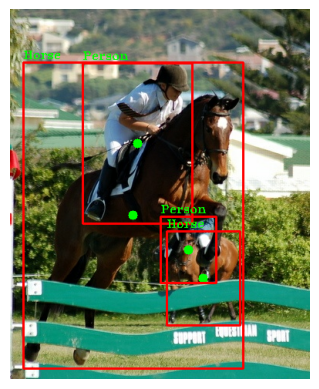

In [5]:
# Define the color of the rectangle (BGR format)
rect_color = (255, 0, 0)  # Red color
point_color = (0, 255, 0)  # Green color
label_font = cv2.FONT_HERSHEY_TRIPLEX
label_font_scale = 0.5
label_font_thickness = 1
thickness = 2

for record in train_ds.take(1):
    img = record['image'].numpy()  # Assuming 'image' is the key
    for bbox, label in zip(record['objects']['bbox'], record['objects']['label']):
        ymin = int(bbox[0].numpy() * img.shape[0])
        xmin = int(bbox[1].numpy() * img.shape[1])
        ymax = int(bbox[2].numpy() * img.shape[0])
        xmax = int(bbox[3].numpy() * img.shape[1])
        point_x = (xmax + xmin) // 2
        point_y = (ymax + ymin) // 2

        # Draw rectangle
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), rect_color, thickness)

        # Draw circle
        cv2.circle(img, (point_x, point_y), 6, point_color, -1)

        # Add label
        class_label = f"{classes[label-1]}"  # Modify this according to your label classes
        label_size = cv2.getTextSize(class_label, label_font,
                                     label_font_scale, label_font_thickness)[0]
        label_x = xmin
        label_y = ymin - 5  # Place the label just above the bounding box
        cv2.putText(img, class_label, (label_x, label_y), label_font,
                    label_font_scale, point_color, label_font_thickness)

plt.imshow(img)
plt.axis('off')
plt.show()

## Encode data into 7x7x30 label_matrix

In [6]:
def preprocess_record(image, bbox_list, label_list):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.
  label_matrix = np.zeros([7, 7, 2 * 5 + NUM_CLASSES], dtype=float)

  for bbox, label in zip(bbox_list, label_list):
    y = (bbox[0] + bbox[2]) / 2
    x = (bbox[1] + bbox[3]) / 2
    h = bbox[2] - bbox[0]
    w = bbox[3] - bbox[1]

    loc = [7 * x, 7 * y]
    loc_i = int(loc[1])
    loc_j = int(loc[0])

    y = loc[1] - loc_i
    x = loc[0] - loc_j

    cls = label  # Assuming label is the class index (0 to NUM_CLASSES - 1)
    if label_matrix[loc_i, loc_j, NUM_CLASSES+4] == 0:
      label_matrix[loc_i, loc_j, cls] = 1
      label_matrix[loc_i, loc_j, NUM_CLASSES:NUM_CLASSES+4] = [x, y, w, h]
      label_matrix[loc_i, loc_j, NUM_CLASSES+4] = 1  # objectness

  return image, label_matrix

def preprocess_dataset(record):
  image = record['image']
  bbox_list = record['objects']['bbox']
  label_list = record['objects']['label']

  image, label_matrix = tf.py_function(
      preprocess_record,
      [image, bbox_list, label_list],
      [tf.float32, tf.float32]
  )

  image.set_shape([IMG_SIZE, IMG_SIZE, 3])
  label_matrix.set_shape([7, 7, 2 * 5 + NUM_CLASSES])

  return image, label_matrix

# Load the dataset
(train_ds, valid_ds, test_ds), ds_info = tfds.load(
    'voc/2007',
    split=['train', 'validation', 'test'],
    with_info=True
)

# Apply the preprocessing function to the datasets and use prefetch
train_ds = train_ds.map(preprocess_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(preprocess_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)

## Decode the label matrix and visualize the data to make sure the data is encoded properly

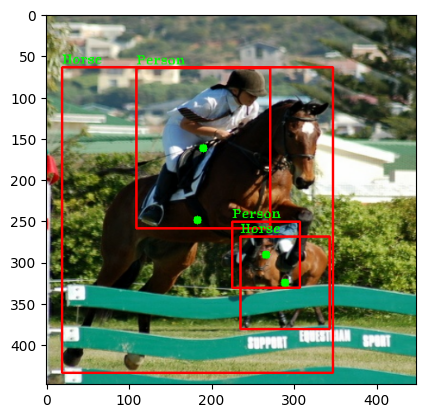

In [7]:
radius = 5
# Define the color of the point (BGR format)
point_color = (0, 255, 0)  # Green color

for image, label_matrix in train_ds.take(1):
  np_img = (image.numpy() * 255).astype('uint8')
  for i in range(7):
    for j in range(7):
      if label_matrix[j, i, NUM_CLASSES+4] == 1:
        point_x = int(((label_matrix[j, i, NUM_CLASSES] + i) / 7) * IMG_SIZE)
        point_y = int(((label_matrix[j, i, NUM_CLASSES+1] + j) / 7) * IMG_SIZE)
        w = int(label_matrix[j, i, NUM_CLASSES+2] * IMG_SIZE)
        h = int(label_matrix[j, i, NUM_CLASSES+3] * IMG_SIZE)

        half_width = w // 2
        half_height = h // 2

        xmin = point_x - half_width
        xmax = point_x + half_width
        ymin = point_y - half_height
        ymax = point_y + half_height
        # print(xmin, xmax, ymin, ymax)
        # Draw center
        cv2.circle(np_img, (point_x, point_y), radius, point_color, -1)
        # Draw rectangle
        cv2.rectangle(np_img, (xmin, ymin), (xmax, ymax), rect_color, thickness)
        # Add label
        label = np.argmax(label_matrix[j, i, :20])
        class_label = f"{classes[label-1]}"  # Modify this according to your label classes
        label_size = cv2.getTextSize(class_label, label_font,
                                     label_font_scale, label_font_thickness)[0]
        label_x = xmin
        label_y = ymin - 5  # Place the label just above the bounding box
        cv2.putText(np_img, class_label, (label_x, label_y), label_font,
                    label_font_scale, point_color, label_font_thickness)

plt.imshow(np_img)
plt.show()

## Yolo Reshape for final layer

In [8]:
class YoloReshape(tf.keras.layers.Layer):
    def __init__(self, target_shape, **kwargs):
        """
        Custom Keras layer to reshape YOLO output tensor.

        Args:
            target_shape: Feature reshape S x S x M
            **kwargs: Additional arguments for the base class constructor.
        """
        super(YoloReshape, self).__init__(**kwargs)
        self.target_shape = target_shape

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'target_shape': self.target_shape,
        })
        return config

    def call(self, inputs):
        """
        Perform reshaping of YOLO output tensor.

        Args:
            inputs (tf.Tensor): Input tensor.

        Returns:
            tf.Tensor: Reshaped tensor.
        """
        S = [self.target_shape[0], self.target_shape[1]]
        B = 2

        idx1 = S[0] * S[1] * NUM_CLASSES
        idx2 = idx1 + S[0] * S[1] * B * 4

        # Class probabilities
        class_probs = tf.reshape(inputs[:, :idx1], (-1, S[0], S[1], NUM_CLASSES))
        class_probs = tf.nn.softmax(class_probs)

        # Boxes
        boxes = tf.reshape(inputs[:, idx1: idx2], (-1, S[0], S[1], B * 4))
        boxes = tf.nn.sigmoid(boxes)

        # Confidence
        confs = tf.reshape(inputs[:, idx2:], (-1, S[0], S[1], B))
        confs = tf.nn.sigmoid(confs)

        outputs = tf.concat([class_probs, boxes, confs], axis=-1)

        return outputs



def YoloV1(input_size):
  # 1 convolution layer block
  inputs = tf.keras.Input(shape=input_size)
  x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding='same', activation=lrelu, kernel_regularizer=l2(5e-4))(inputs)
  x = tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same')(x)

  # 1 convolution layer block
  x = tf.keras.layers.Conv2D(192, (3, 3), padding='same', activation=lrelu, kernel_regularizer=l2(5e-4))(x)
  x = tf.keras.layers.MaxPool2D((2, 2), strides=2,  padding='same')(x)

  # 4 convolution layers block
  x = tf.keras.layers.Conv2D(128, (1, 1), padding='same', activation=lrelu, kernel_regularizer=l2(5e-4))(x)
  x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation=lrelu, kernel_regularizer=l2(5e-4))(x)
  x = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation=lrelu, kernel_regularizer=l2(5e-4))(x)
  x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation=lrelu, kernel_regularizer=l2(5e-4))(x)
  x = tf.keras.layers.MaxPool2D((2, 2), strides=2,  padding='same')(x)

  # 10 Convolution layers block
  for _ in range(4):
    x = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation=lrelu, kernel_regularizer=l2(5e-4))(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation=lrelu, kernel_regularizer=l2(5e-4))(x)
  x = tf.keras.layers.Conv2D(512, (1, 1), padding='same', activation=lrelu, kernel_regularizer=l2(5e-4))(x)
  x = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation=lrelu, kernel_regularizer=l2(5e-4))(x)
  x = tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same')(x)

  # 6 convolution layers block
  for _ in range(2):
    x = tf.keras.layers.Conv2D(512, (1, 1), padding='same', activation=lrelu, kernel_regularizer=l2(5e-4))(x)
    x = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation=lrelu, kernel_regularizer=l2(5e-4))(x)
  x = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation=lrelu, kernel_regularizer=l2(5e-4))(x)
  x = tf.keras.layers.Conv2D(1024, (3, 3), strides=2, padding='same')(x)

  # 2 convolution layers block
  x = tf.keras.layers.Conv2D(1024, (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4))(x)
  x = tf.keras.layers.Conv2D(1024, (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4))(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512)(x)
  x = tf.keras.layers.Dense(1024)(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(1470, activation='sigmoid')(x)
  outputs = YoloReshape(target_shape=(7, 7, 30))(x)

  return tf.keras.Model(inputs=inputs, outputs=outputs)

## Utility functions for loss

In [9]:
def xywh2minmax(xy, wh):
    """
    Convert bounding box coordinates from center-width-height format to min-max format.

    Args:
        xy (tf.Tensor): Tensor containing bounding box centers.
        wh (tf.Tensor): Tensor containing bounding box widths and heights.

    Returns:
        xy_min (tf.Tensor): Tensor containing minimum coordinates of bounding boxes.
        xy_max (tf.Tensor): Tensor containing maximum coordinates of bounding boxes.
    """
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2
    return xy_min, xy_max

def iou(pred_mins, pred_maxs, true_mins, true_maxs):
    """
    Calculate Intersection over Union (IoU) scores between predicted and true bounding boxes.

    Args:
        pred_mins (tf.Tensor): Tensor containing predicted bounding box minimum coordinates.
        pred_maxs (tf.Tensor): Tensor containing predicted bounding box maximum coordinates.
        true_mins (tf.Tensor): Tensor containing true bounding box minimum coordinates.
        true_maxs (tf.Tensor): Tensor containing true bounding box maximum coordinates.

    Returns:
        iou_scores (tf.Tensor): Tensor containing IoU scores for each bounding box pair.
    """

    # Calculate intersection coordinates and dimensions
    intersect_mins = tf.maximum(pred_mins, true_mins)
    intersect_maxs = tf.minimum(pred_maxs, true_maxs)
    intersect_wh = tf.maximum(intersect_maxs - intersect_mins, 0.0)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    # Calculate areas of predicted and true bounding boxes
    pred_wh = pred_maxs - pred_mins
    true_wh = true_maxs - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

     # Calculate union areas and IoU scores
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores

def yolo_head(feats):
    """
    Compute the bounding box coordinates and dimensions from YOLO model features.

    Args:
        feats (tf.Tensor): Tensor containing YOLO model features.
        img_size (int): Size of the input image.

    Returns:
        box_xy (tf.Tensor): Tensor containing bounding box centers.
        box_wh (tf.Tensor): Tensor containing bounding box widths and heights.
    """
    # Calculate convolution dimensions and indices for each grid cell
    conv_dims = tf.shape(feats)[1:3]
    conv_height_index = tf.range(0, limit=conv_dims[0])
    conv_width_index = tf.range(0, limit=conv_dims[1])
    conv_height_index = tf.tile(conv_height_index, [conv_dims[1]])

    conv_width_index = tf.tile(
        tf.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = tf.reshape(tf.transpose(conv_width_index), [-1])
    conv_index = tf.stack([conv_height_index, conv_width_index], axis=1)
    conv_index = tf.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = tf.cast(conv_index, feats.dtype)
    conv_dims = tf.cast(tf.reshape(conv_dims, [1, 1, 1, 1, 2]), feats.dtype)

    # Calculate bounding box centers (x, y) for each grid cell
    box_xy = (feats[..., :2] + conv_index) / conv_dims * IMG_SIZE

    # Calculate bounding box widths and heights using model predictions
    box_wh = feats[..., 2:4] * IMG_SIZE

    return box_xy, box_wh


## Custom YOLO loss

In [10]:
class YOLOLoss(tf.keras.losses.Loss):
  def __init__(self, S, B, C, lambda_coord=5.0, lambda_noobj=0.5, name='yolo_loss'):
    """
    Custom YOLO loss function for object detection.

    Args:
        S (int): The number of grid cells in one dimension.
        B (int): The number of anchor boxes per grid cell.
        C (int): The number of classes.
        lambda_coord (float): The weight for coordinate loss.
        lambda_noobj (float): The weight for no-object confidence loss.
        name (str): The name of the loss function.
    """
    super(YOLOLoss, self).__init__(name=name)
    self.S = S
    self.B = B
    self.C = C
    self.lambda_coord = lambda_coord
    self.lambda_noobj = lambda_noobj

  def call(self, y_true, y_pred):
    """
    Calculate the YOLO loss for object detection.

    Args:
        y_true (tf.Tensor): The true labels (ground truth).
        y_pred (tf.Tensor): The predicted labels from the model.

    Returns:
        tf.Tensor: The calculated YOLO loss.
    """
    # Extracting predicted values
    pred_class = y_pred[..., :self.C]
    pred_boxes = y_pred[..., self.C:self.C + self.B * 4]
    pred_conf = y_pred[..., self.C + self.B * 4:]

    # Extracting true values
    true_class = y_true[..., :self.C]
    true_box = y_true[..., self.C:self.C + 4]
    true_conf = y_true[..., self.C + 4]
    response_mask = tf.expand_dims(true_conf, axis=-1)

    _true_box = tf.reshape(true_box, shape=(-1, 7, 7, 1, 4)) # None x 7 x 7 x 1 x 4
    _predict_box = tf.reshape(pred_boxes, shape=(-1, 7, 7, 2, 4)) # None x 7 x 7 x 2 x 4

    label_xy, label_wh = yolo_head(_true_box)  # None x 7 x 7 x 1 x 2, None x 7 x 7 x 1 x 2
    label_xy = tf.expand_dims(label_xy, axis=3)  # None x 7 x 7 x 1 x 1 x 2
    label_wh = tf.expand_dims(label_wh, axis=3)  # None x 7 x 7 x 1 x 1 x 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # None x 7 x 7 x 1 x 1 x 2, None x 7 x 7 x 1 x 1 x 2

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = tf.expand_dims(predict_xy, 4)  # None * 7 * 7 * 2 * 1 * 2
    predict_wh = tf.expand_dims(predict_wh, 4)  # None * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # None x 7 x 7 x 2 x 1 x 2, None x 7 x 7 x 2 x 1 x 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    best_ious = tf.reduce_max(iou_scores, axis=4)  # None x 7 x 7 x 2

    best_box = tf.reduce_max(best_ious, axis=3, keepdims=True)  # None x 7 x 7 x 1
    box_mask = tf.cast(best_ious >= best_box, dtype=best_ious.dtype)  # None x 7 x 7 x 2
    no_object_loss = 0.5 * (1 - box_mask * response_mask) * tf.square(0 - pred_conf)

    object_loss = box_mask * response_mask * tf.square(1 - pred_conf)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = tf.reduce_sum(confidence_loss)
    class_loss = response_mask * tf.square(true_class - pred_class)
    class_loss = tf.reduce_sum(class_loss)

    _true_box = tf.reshape(true_box, shape=(-1, 7, 7, 1, 4)) # None x 7 x 7 x 1 x 4
    _predict_box = tf.reshape(pred_boxes, shape=(-1, 7, 7, 2, 4)) # None x 7 x 7 x 2 x 4

    label_xy, label_wh = yolo_head(_true_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = tf.expand_dims(box_mask, axis=-1)
    response_mask = tf.expand_dims(response_mask, axis=-1)

    box_loss = 5 * box_mask * response_mask * tf.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * tf.square((tf.sqrt(label_wh) - tf.sqrt(predict_wh)) / 448)
    box_loss = tf.reduce_sum(box_loss)

    loss = confidence_loss + class_loss + box_loss
    # tf.print(loss)
    return loss

# Example usage
S = 7
B = 2
C = 20
lambda_coord = 5.0
lambda_noobj = 0.5

loss_fn = YOLOLoss(S, B, C, lambda_coord, lambda_noobj)


## Learning Rate scheduler

In [40]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = self.model.optimizer.lr.numpy() # Change is here
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        self.model.optimizer.lr.assign(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.01),
    (75, 0.001),
    (105, 0.0001),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

## Compile model with mirrored strategy to train using GPU

In [41]:
with strategy.scope():
  model = YoloV1((448, 448, 3))
  model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, nesterov=True),
              loss=tf.keras.losses.categorical_crossentropy, metrics=["accuracy"])

NameError: name 'keras' is not defined

In [33]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 448, 448, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_216 (Conv2D)                  │ (None, 224, 224, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_217 (Conv2D)                  │ (None, 112, 112, 192)       │         110,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 56, 56, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_218 (Conv2D)                  │ (None, 56, 56, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_219 (Conv2D)                  │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_220 (Conv2D)                  │ (None, 56, 56, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_221 (Conv2D)                  │ (None, 56, 56, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_222 (Conv2D)                  │ (None, 28, 28, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_223 (Conv2D)                  │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_224 (Conv2D)                  │ (None, 28, 28, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_225 (Conv2D)                  │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_226 (Conv2D)                  │ (None, 28, 28, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_227 (Conv2D)                  │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_228 (Conv2D)                  │ (None, 28, 28, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_229 (Conv2D)                  │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_230 (Conv2D)                  │ (None, 28, 28, 512)         │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_231 (Conv2D)                  │ (None, 28, 28, 1024)        │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 14, 14, 1024)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 66,907,134 (255.23 MB)

 Trainable params: 66,907,134 (255.23 MB)

 Non-trainable params: 0 (0.00 B)

## Train model with fit method

In [43]:
history = model.fit(train_ds.batch(BATCH_SIZE),
                    validation_data=valid_ds.batch(BATCH_SIZE),
                    epochs=10)

ValueError: You must call `compile()` before using the model.

In [ ]:
model.save('trained_model.h5')